In [1]:
import random
import re
import pandas as pd
import numpy as np
import json
import string
from tqdm import tqdm

with open("F:/WB/Supporting Files/combined_slang_words.txt") as f:
    slang_words_dict = json.load(f)

with open("F:/WB/Supporting Files/combined_stop_words.txt") as f:
    stop_words_list = f.read().splitlines()


def deEmojify(inputString):
    '''
    Function to remove emoji
    '''
    return inputString.encode('ascii', 'ignore').decode('ascii')


def isfloat(value):
    ''' 
    Check if value is float or not
    '''
    try:
        float(value)
        return True
    except ValueError:
        return False


def elongated_word(word):
    """
    Replaces an elongated word with its basic form, unless the word exists in the lexicon 
    """
    count = {}
    for s in word:
        if s in count:
            count[s] += 1
        else:
            count[s] = 1

    for key in count:
        if count[key]>2:
            return ''
            break
    
    return word


def word_cleaner(word):
    '''
    clean input word
    '''
    #Transfrom slang word into its normal words based on slang_words corpus
    if word in slang_words_dict.keys():
        word = slang_words_dict[word]

    #Transform elongated word to normal word
    if (not isfloat(word)) and (word!=''):
        word = elongated_word(word)

    return word


def sentences_cleaner(sentence):
    '''
    clean input sentence  
    '''
    mention_pat= r'@[A-Za-z0-9_]+'
    mention_2_pat=r'@[A-Za-z0-9_]+:\s'
    http_pat = r'https?://[^ ]+'
    www_pat = r'www.[^ ]+'
    hashtag_pat = r'#[A-Za-z0-9_]+'
    linebreak_pat = r'\n'

    #Remove Emoji
    stripped = deEmojify(sentence)

    #Delete mention
    stripped = re.sub(mention_2_pat,'', stripped)
    stripped = re.sub(mention_pat,'', stripped)

    #Remove url
    stripped = re.sub(http_pat, '', stripped)
    stripped = re.sub(www_pat, '', stripped)

    #Remove hashtag
    stripped = re.sub(hashtag_pat, '', stripped)

    #Remove linebreak
    stripped = re.sub(linebreak_pat,'',stripped)

    #Remove Punctuation
    stripped = [re.sub(r'[^\w\s]',' ',x) for x in stripped.split(string.punctuation)][0]

    #Remove Non Alphabet and Non Number Characters
    stripped = re.sub(' +',' ',re.sub(r'[^a-zA-Z-0-9]',' ',stripped)).strip()

    #Lowercase 
    stripped = stripped.lower()

    #Clean word by word
    stripped = ' '.join(pd.Series(stripped.split()).apply(lambda x: word_cleaner(x)).to_list())

    #remove stop words
    lst = pd.Series(stripped.split()).apply(lambda x: 'stopword' if x in stop_words_list else x).to_list()
    lst = [wrd for wrd in lst if wrd!='stopword']
    stripped = ' '.join(lst)

    # #Stem each word
    # stripped = stemmer.stem(stripped)

    # #Sanity check using Kateglo API
    # check = pd.Series(stripped.split()).apply(lambda x: check_kateglo(x)).to_list()
    # check = [wrd for wrd in check if wrd!='']
    # stripped = ' '.join(check)

    return re.sub(' +',' ',stripped).strip()

In [2]:
from wordcloud import WordCloud, ImageColorGenerator
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import urllib.request

def Google_Translate_API(word):
    '''
    API to Google Translate
    '''
    url = 'https://translate.google.com/m?sl=%s&tl=%s&ie=UTF-8&prev=_m&q=%s' % ('id', 'en',word.replace(" ","+")) 
    agent = {'User-Agent':'Mozilla/5.0'}
    request = urllib.request.Request(url, headers=agent)
    page = urllib.request.urlopen(request).read().decode('utf-8')
    result = page.split('class="t0">')[1].split('<')[0]
    return result

df_evolution_weekly = pd.read_csv('F:/WB/Issue Monitoring/data/gdelt_TOP_10_Evolution_Weekly_Similar_Issue_Keyword.csv')
# df_evolution_weekly = pd.read_csv('F:/WB/Issue Monitoring/data/Sentiment_Evolution_Weekly_Similar_Issue_Keyword.csv')

#Extract New Normal Keyword List
forbidden_keywords_list = []
with open('F:/WB/Issue Monitoring/forbidden_keywords.txt','r') as f:
	for line in f:
		forbidden_keywords_list.append(re.sub('\n','',line).lower())

SOURCE_new_normal = 'F:/WB/Issue Monitoring/topic/new_normal/'
_,_,filenames_new_normal = next(os.walk(SOURCE_new_normal))

new_normal_keyword_list = []

for topic_file in filenames_new_normal:
    with open(SOURCE_new_normal + topic_file, "r") as f:
        for line in f:
            new_normal_keyword_list.append(sentences_cleaner(line))

new_normal_keyword_list = [new_normal_keyword_list[i] for i in range(len(new_normal_keyword_list)) if new_normal_keyword_list[i] not in forbidden_keywords_list]

#Filter only new normal keyword list
df_evolution_weekly = df_evolution_weekly[df_evolution_weekly['keyword'].isin(new_normal_keyword_list)].reset_index(drop=True)

#Data Preparation
df_evolution_weekly_prepared = pd.DataFrame(columns=['topic','week','keyword','count'])
for topic in list(df_evolution_weekly['topic'].unique()):
    df_temp = df_evolution_weekly[df_evolution_weekly.topic==topic]
    for week in list(df_temp['week_of_the_year'].unique()):
        df_temp_daily = df_temp[df_temp.week_of_the_year==week].reset_index(drop=True)
        for i in range(len(df_temp_daily)):
            df_evolution_weekly_prepared = df_evolution_weekly_prepared.append({'topic':topic,'week':week,'keyword':df_temp_daily.loc[i,'keyword'],'count':df_temp_daily.loc[i,'keyword_count']},ignore_index=True)

            df_evolution_weekly_prepared = df_evolution_weekly_prepared.append({'topic':topic,'week':week,'keyword':df_temp_daily.loc[i,'similar_keyword'],'count':df_temp_daily.loc[i,'similar_keyword_count']},ignore_index=True)

df_evolution_weekly_prepared = df_evolution_weekly_prepared.drop_duplicates()
df_evolution_weekly_prepared = df_evolution_weekly_prepared[df_evolution_weekly_prepared['week']>=19].reset_index(drop=True)

Generating 100% Stacked Area Chart for Topic: economic policy


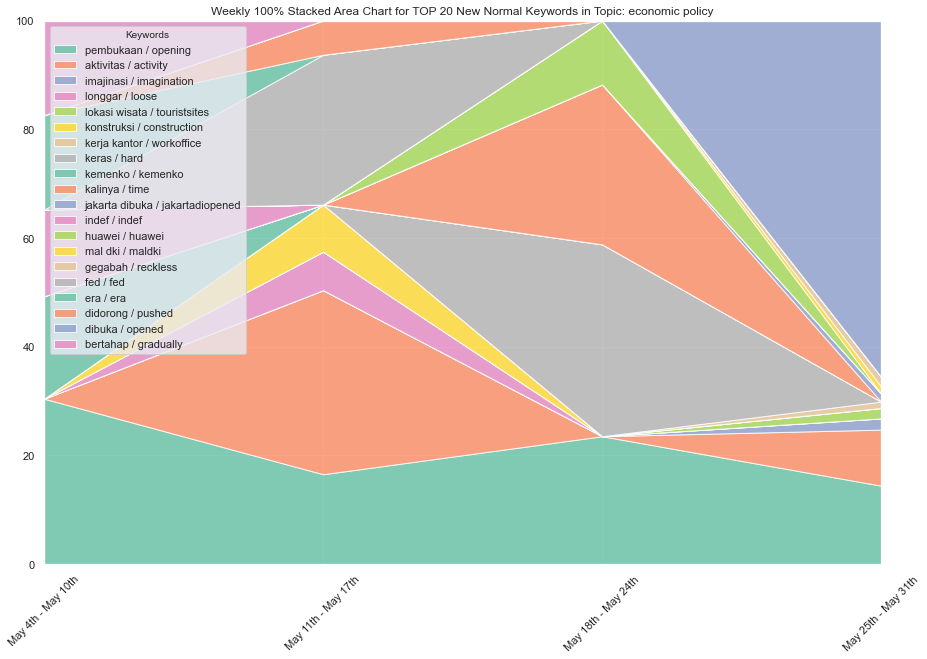

Generating 100% Stacked Area Chart for Topic: health care


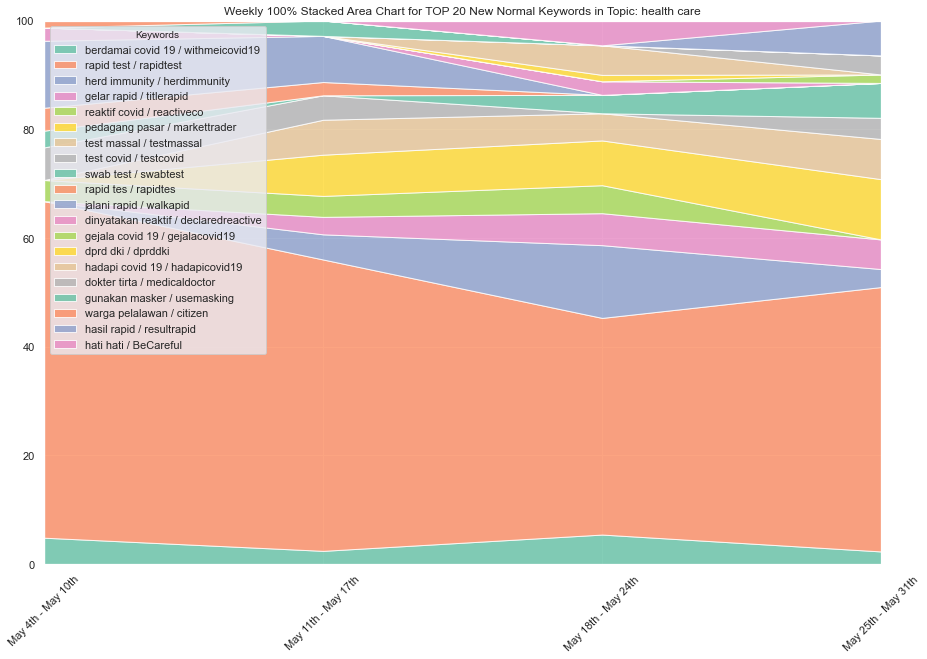

Generating 100% Stacked Area Chart for Topic: confidence in government


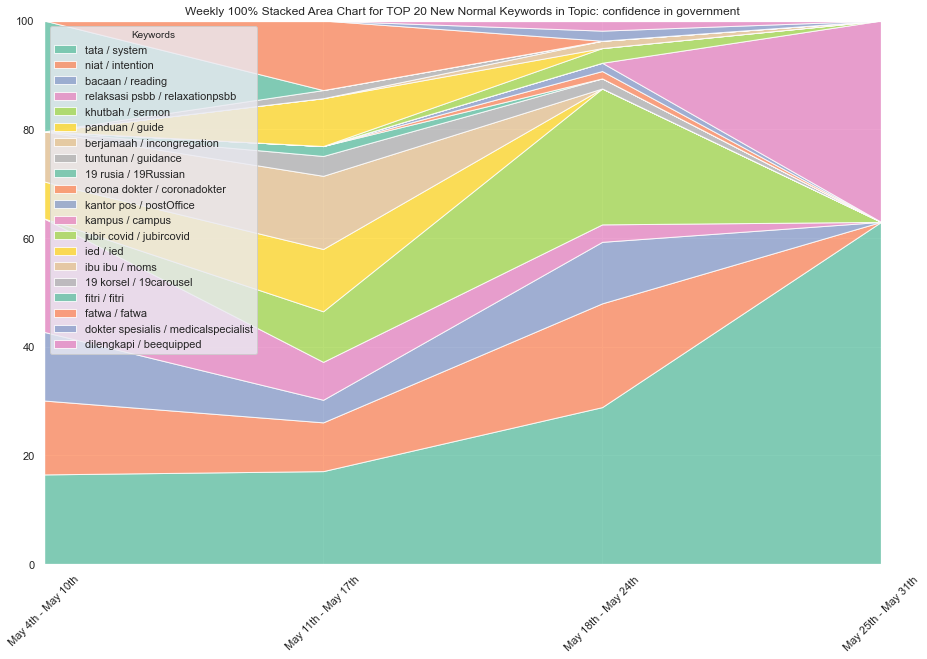

Generating 100% Stacked Area Chart for Topic: mobility


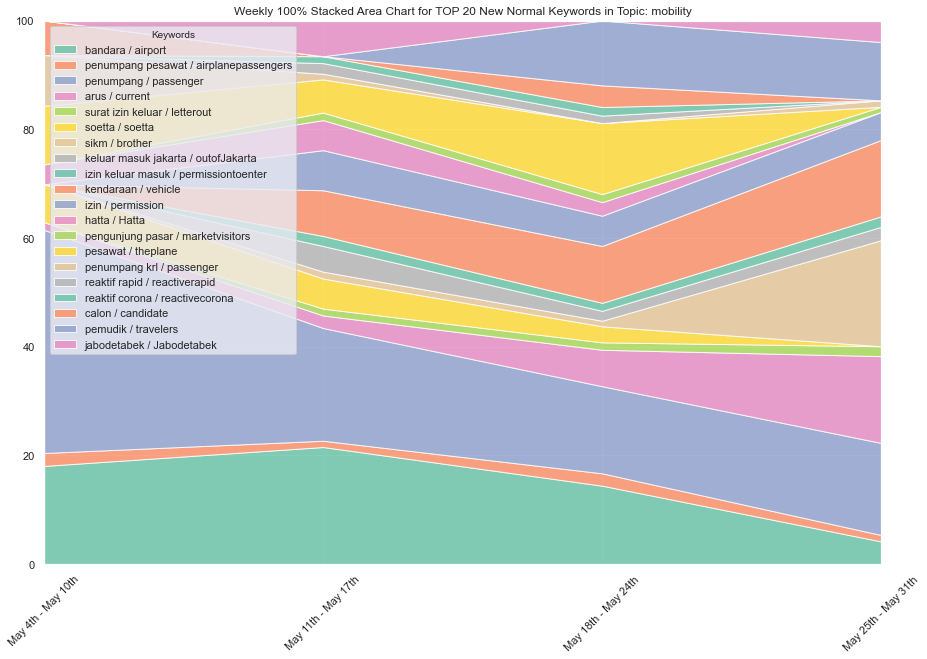

Generating 100% Stacked Area Chart for Topic: employment


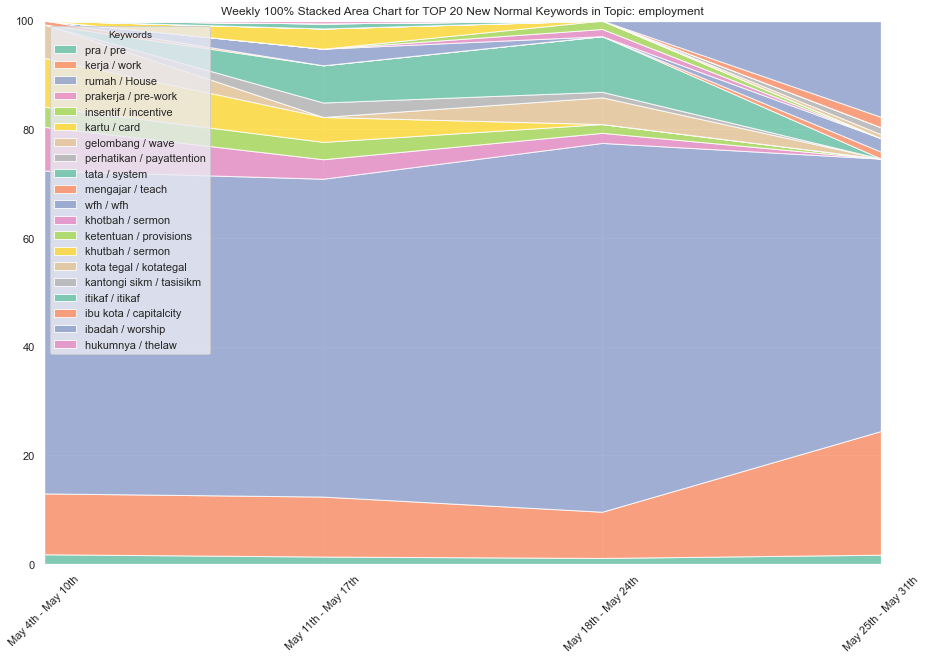

Generating 100% Stacked Area Chart for Topic: health protocol


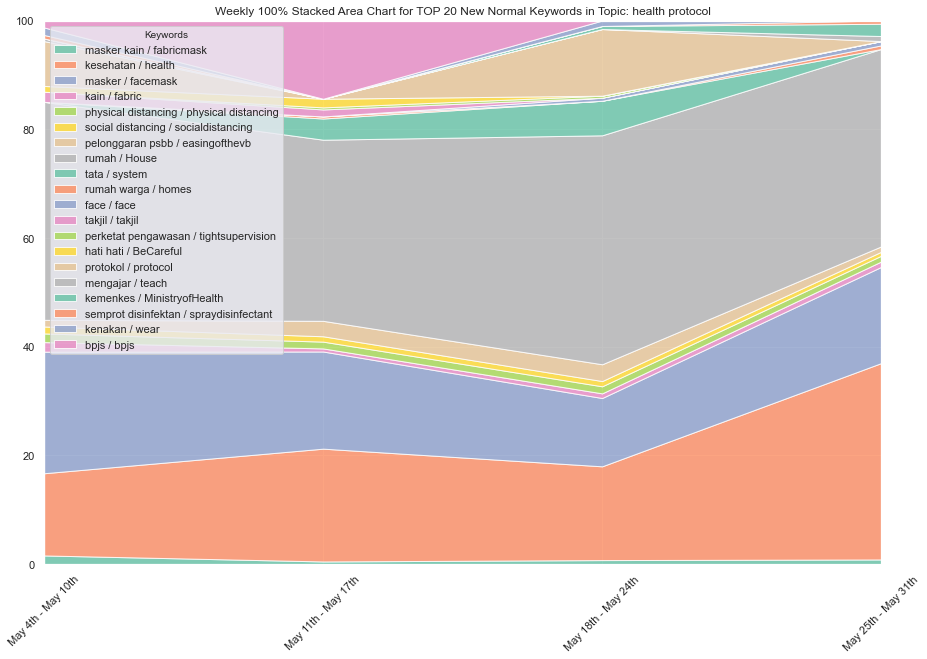

In [3]:
translate_dict={'bantuan':'aid',
'apd':'ppe',
'garda':'guard',
'psbb':'lssr',
'drpd':'instead of',
'jgn':'do not',
'garda terdepan':'front guard',
'hasile':'result',
'kasi':'give',
'kasih' : 'give',
'gausah':'no need',
'liwat':'through',
'santuy':'relax',
'kenacorona':'infectedbycorona',
'videowarga':'citizensvideo',
'dunia covid':'covid world',
'warga menolak':'citizens refused',
'jenazah covid':'covid corpse',
'jenazah covid19':'covid19 corpse',
'jenazah corona':'corona corpse',
'mudik':'mudik',
'dilarang mudik':'prohibited to mudik',
'kampung lindungi':'protect the village',
'19 ditolak':'19 rejected',
'jenazah dalam':'corpse inside',
'nolak jenazah':'refuse corpse',
'didoakan musuh':'prayed by the enemies',
'ditolak gede':'big refusal',
'ditolak tpu':'refuse tpu',
'dki bertambah':'dki increases',
'jawa menghadang':'jawa blocks',
'depok kota':'depok city',
'rs rujukan':'referral hospital',
'rs darurat':'emergency hospital',
'nakes':'healthworkers',
'atlet kemayoran':'kemayoran athletes',
"wisma atlet":"athelete's homestead",
'pelindung apd':'ppe protector',
'atlet rs':'athlete hospital',
'masker n95':'n95 mask',
'bedah n95':'n95 surgery',
'n95 petugas':'n95 officer',
'kartu pra kerja':'pre work card',
'kartu prakerja':'prework card',
'19 achmad':'19 achmad',
'2 meter':'2 meters',
'2m':'2m',
'4m':'4m',
'25m':'25m',
'05m':'05m',
'1 meter':'1 meter',
'2mfacility':'2mfacilities',
'80rbkain':'80 thousands fabric',
'rumah keperluan':'home needs',
'rumah urgent': 'house urgent',
'keluar dalem':'inside out',
'physical distancing':'physical distancing',
'blt' : 'cash transfer',
'phk': 'work termination',
'sdm' : 'human resources'}

week_dict = {
    19 : 'May 4th - May 10th',
    20 : 'May 11th - May 17th',
    21 : 'May 18th - May 24th',
    22 : 'May 25th - May 31th'
}

for topic in list(df_evolution_weekly_prepared['topic'].unique()):
    print('Generating 100% Stacked Area Chart for Topic: {}'.format(topic))
    # df_sentiment_filter = df_sentiment_daily[df_sentiment_daily.topic==topic]
    df_filter = df_evolution_weekly_prepared[df_evolution_weekly_prepared.topic==topic]
    if topic == 'stigma':
        exclude_keyword_list = ['susu']
    elif topic =='health protocol':
        exclude_keyword_list = ['aja']
    else:
        exclude_keyword_list = []
    df_filter = df_filter[~df_filter['keyword'].isin(exclude_keyword_list)]
    TOP_20_keywords = list(df_filter.groupby('keyword').count()['count'].sort_values(ascending=False).head(20).index)
    
    translated_TOP_20_keywords = []
    for i in range(20):
        try:
            translated_TOP_20_keywords.append(translate_dict[TOP_20_keywords[i]])
        except:
            try:
                translated_TOP_20_keywords.append(re.sub(r'[^a-zA-Z-0-9]','',Google_Translate_API(re.sub(r'[^a-zA-Z-0-9]','',TOP_20_keywords[i]))))
            except:
                translated_TOP_20_keywords.append(TOP_20_keywords[i])

    df_filter = df_filter[df_filter['week']<=22]
    df_filter = df_filter.sort_values(by='week').reset_index(drop=True)
    df_filter = df_filter[df_filter['keyword'].isin(TOP_20_keywords)].reset_index(drop=True)
    week_list = list(df_filter['week'].unique())
    x = [week_dict[week] for week in week_list]
    y = []
    legend = []
    i=0
    for keyword in TOP_20_keywords:
        yy = []
        df_filter_keyword = df_filter[df_filter['keyword']==keyword]
        for week in week_list:
            try:
                yy.append(df_filter_keyword[df_filter_keyword.week==week]['count'].values[0])
            except:
                yy.append(0)
        y.append(yy)
        legend.append(keyword + ' / ' + translated_TOP_20_keywords[i])
        i+=1
    
    y = np.vstack(y)
    y = y /  y.sum(axis=0).astype(float) * 100 

    fig, ax1 = plt.subplots(figsize=(15,10))
    plt.title("Weekly 100% Stacked Area Chart for TOP 20 New Normal Keywords in Topic: {}".format(topic))
    pal = sns.color_palette("Set2")
    ax1.stackplot(x, y, labels=legend,colors=pal,alpha=0.8)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(legend,loc='upper left',title="Keywords")
    ax1.set_xlim([x[0],x[-1]])
    ax1.set_ylim([0,100])
    plt.show()
    fig.savefig('chart_output/gdelt_weekly_keyword_evolution_{}_new_normal.png'.format(topic), dpi=fig.dpi)